<a href="https://colab.research.google.com/github/cabanillapril/AI/blob/main/A1_Sentiment_Analysis_Using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Bernal, Almarc

Bodano, Ken Jasmer

Cabanilla, April Anne

Francisco, Aldwin Rex

Lim, Anna Grace

## Import Libraries

This section imports all essential Python libraries for the project, including TensorFlow/Keras for modeling, NumPy for numerical operations, Matplotlib for visualizations, and KaggleHub for retrieving additional datasets. These imports establish the tools needed for data loading, preprocessing, model training, and evaluation. In a production workflow, this ensures all dependencies required for NLP processing and machine learning are available at runtime.

In [ ]:
from tensorflow.keras.datasets import imdb

import tensorflow as tf
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt

## Loading datasets

### IMDB Dataset

The IMDB dataset is sourced from Keras, offering 50,000 movie reviews already encoded as integer sequences. Each sequence corresponds to the frequency ranking of words, and each label indicates whether a review is positive or negative. Since the dataset does not provide raw text, an integer-to-word mapping must be reconstructed. This reverse mapping is crucial because many NLP preprocessing steps—such as cleaning, stopword removal, and exploratory text analysis—require human-readable strings. Additionally, custom token markers like [START] and [OOV] ensure consistent interpretation of the tokenized data.


In [ ]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3

In [ ]:
# Retrieve the training sequences.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(start_char=start_char, oov_char=oov_char, index_from=index_from)

# Retrieve the word index file mapping words to indices
word_index = imdb.get_word_index()

In [ ]:
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict((i + index_from, word) for (word, i) in word_index.items())

# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[1] = "[START]"
inverted_word_index[2] = "[OOV]"

### Stopwords Dataset

To support thorough text cleaning, the project imports a stopword list from a Kaggle dataset. These stopwords include high-frequency words that typically do not contribute meaningfully to sentiment classification. By removing them, the system reduces data noise, enhances model efficiency, and improves signal extraction. Using an externally maintained dataset ensures standardization and consistency across different text sources.

In [ ]:
# Download stopwords dataset from Kaggle
stopwords = kagglehub.dataset_download("amirhoseinsedaghati/english-stopwords")

Using Colab cache for faster access to the 'english-stopwords' dataset.


In [ ]:
import os
stopwords_file = os.path.join(stopwords, "EN-Stopwords.txt")

with open(stopwords_file, "r", encoding="utf-8") as f:
    stopwords_list = [line.strip() for line in f.readlines()]

#print(stopwords_list[:20])  # see the first 20 stopwrods

## Preprocess the Text

### Translating integer sequences to actual words
The IMDB dataset from Keras stores reviews in the form of integer sequences. Each integer corresponds to a word from the word index that we also imported from Keras.

In [ ]:
# Function for translating the integers to words
def translate(review):
    return " ".join(inverted_word_index[i] for i in review)

print(test_data[0])

[1, 591, 202, 14, 31, 6, 717, 10, 10, 18142, 10698, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 15387, 38, 32, 25, 7944, 451, 202, 14, 6, 717]


In [ ]:
# Convert integers to words
translated_train_data = [translate(review) for review in train_data]
translated_test_data = [translate(review) for review in train_data]

print(translated_test_data[0])

[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sho

### Removing stopwords from the dataset
Stop words are commonly used words (such as "the," "is," "and," etc.) that are frequently occurring but typically do not contribute much to the overall meaning of the text. In natural language processing (NLP) tasks, it is often beneficial to remove stop words before further analysis or modeling. Removing stop words can help reduce noise, decrease the dimensionality of the data, and potentially improve the performance of tasks such as text classification, sentiment analysis, topic modeling, and information retrieval.

In [ ]:
# Function for removing stopwords from the reviews
def remove_stopwords(text):
    # Split text into words, filter out stopwords, then join back
    return " ".join([word for word in text.split() if word not in stopwords_list])

In [ ]:
# Removes the stopwords
preprocessed_train_data = [remove_stopwords(review) for review in translated_train_data]
preprocessed_test_data = [remove_stopwords(review) for review in translated_test_data]

print(preprocessed_test_data[0])

[START] film brilliant casting location scenery story direction everyone's suited played imagine robert redford's amazing actor director norman's father scottish island loved real connection film witty remarks film brilliant bought film released retail recommend watch fly fishing amazing cried sad film congratulations boy's played part's norman paul brilliant children left praising list stars play grown profile film children amazing praised story lovely true someone's life shared


## Exploratory Data Analysis

The exploratory phase identifies trends and patterns within the dataset before any model training occurs. By isolating positive and negative reviews, the system generates word frequency lists to examine which words dominate each sentiment category. Visualizing these results confirms whether preprocessing—such as stopword removal and token filtering—has been applied correctly. This step also provides insights into sentiment drivers and helps validate assumptions about the data. EDA is essential for detecting anomalies, understanding vocabulary distribution, and ensuring that downstream modeling steps are built upon clean and reliable text data.

In [ ]:
def get_top_words(reviews, labels, sentiment, top_n=20):
    """Get top N most frequent words for a given sentiment."""
    # Filter reviews by sentiment
    sentiment_reviews = [reviews[i] for i in range(len(reviews)) if labels[i] == sentiment]

    # Count word frequencies
    word_freq = {}
    for review in sentiment_reviews:
        words = review.split()
        for word in words:
            if word not in ['[START]', '[OOV]']:  # Skip special tokens
                word_freq[word] = word_freq.get(word, 0) + 1

    # Sort by frequency and get top N
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:top_n]

# Get top words for positive and negative reviews
top_positive_words = get_top_words(preprocessed_train_data, train_labels, sentiment=1, top_n=20)
top_negative_words = get_top_words(preprocessed_train_data, train_labels, sentiment=0, top_n=20)

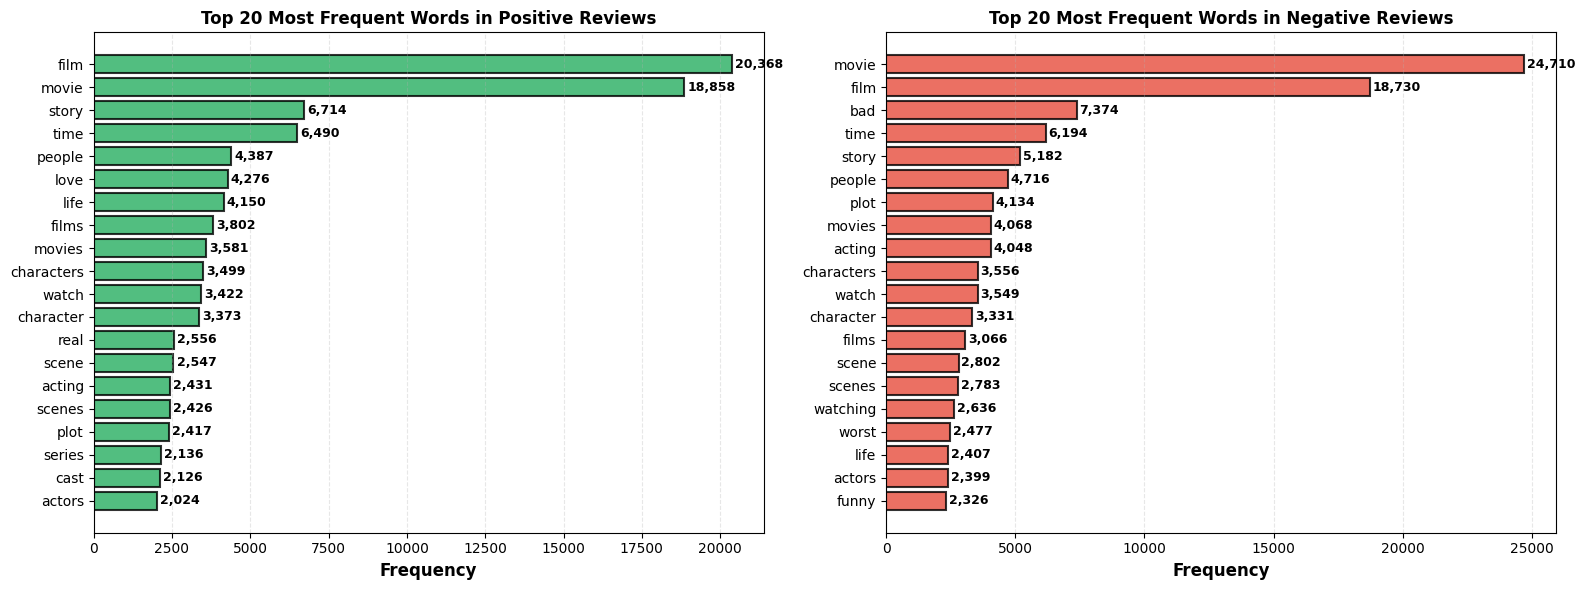

In [ ]:
# Visualize top frequent words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive reviews
pos_words = [word for word, count in top_positive_words]
pos_counts = [count for word, count in top_positive_words]

axes[0].barh(pos_words, pos_counts, color='#27AE60', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Top 20 Most Frequent Words in Positive Reviews', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Add count labels
for i, (word, count) in enumerate(zip(pos_words, pos_counts)):
    axes[0].text(count + 100, i, f'{count:,}', va='center', fontsize=9, fontweight='bold')

# Negative reviews
neg_words = [word for word, count in top_negative_words]
neg_counts = [count for word, count in top_negative_words]

axes[1].barh(neg_words, neg_counts, color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Top 20 Most Frequent Words in Negative Reviews', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# Add count labels
for i, (word, count) in enumerate(zip(neg_words, neg_counts)):
    axes[1].text(count + 100, i, f'{count:,}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('top_frequent_words.png', dpi=300, bbox_inches='tight')
plt.show()

### Insights

**1. Word overlap / least important features**

Many words appear frequently in BOTH positive and negative reviews:
  *   "film": 20,468 (positive) vs 18,730 (negative)
  *   "movie": 18,858 (positive) vs 24,710 (negative)
  *   "time": 6,490 (positive) vs 6,194 (negative)
  *   "story": 6,714 (positive) vs 5,182 (negative)
  *   "people", "character", "scene", "acting" - all appear in both
These neutral words don't help distinguish sentiment, which can reduce model accuracy since they appear frequently but carry no sentiment signal.

**2. Strong sentiment indicators**

Some words are unique to the sentiment.
Positive sentiment indicators:
  *   "love" (4,276) - only in positive
  *   "life" (4,150) - only in positive
Negative sentiment indicators:
  *   "bad" (7,374) - only in negative
  *   "worst" (2,477) - only in negative

1. Word overlap / least useful features
Many high-frequency words appear in both positive and negative reviews, for example “film,” “movie,” “time,” “story,” “people,” “character,” “scene,” and “acting.”
Based on the provided counts, these words occur thousands of times on both sides with similar frequencies. Because they are neutral and common to all reviews, they carry little to no sentiment information. When included as features, they can add noise and make it harder for the model to clearly separate positive from negative opinions.

2. Strong sentiment indicators
Some words clearly signal sentiment because they appear only on one side:



*   Positive indicators: words like “love” and “life” occur only in
positive reviews in the given data.
*   Negative indicators: words such as “bad” and “worst” appear only in negative reviews.

These words are much more informative because their presence strongly suggests the review’s sentiment. Models generally benefit more from these features than from neutral, overlapping words.
In short: neutral words describe the topic, while sentiment-specific words express opinion—those opinion words are far more valuable for sentiment classification, based on the counts you provided.

## Bag-of-Words

In this phase, the cleaned text is converted into numerical vectors using Bag-of-Words representation. This method counts word occurrences without considering word order, resulting in a high-dimensional but interpretable representation of the text. After building a vocabulary capped at 10,000 words, each review becomes a fixed-length vector representing word frequency. A logistic regression model is then trained using these vectors. The BoW model serves as the baseline for comparison due to its simplicity, high transparency, and predictable behavior in sentiment classification tasks.

### Feature Extraction

In [ ]:
vectorizer_bow = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='count',
    output_sequence_length=None
)

# Adapt to training data
vectorizer_bow.adapt(preprocessed_train_data)

# Transform data
X_train_bow = vectorizer_bow(preprocessed_train_data).numpy()
X_test_bow = vectorizer_bow(preprocessed_test_data).numpy()

print(f"BoW Training shape: {X_train_bow.shape}")
print(f"BoW Test shape: {X_test_bow.shape}")
print(f"Vocabulary size: {len(vectorizer_bow.get_vocabulary())}")

BoW Training shape: (25000, 10000)
BoW Test shape: (25000, 10000)
Vocabulary size: 10000


### Training

In [ ]:
# Build Logistic Regression Model with BoW (Single Dense Layer with Sigmoid)
model_bow = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_bow.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Logistic Regression
], name='BoW_Model')

model_bow.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model_bow.summary()

# Train the model
history_bow = model_bow.fit(
    X_train_bow, train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    verbose=1
)


Building Logistic Regression model with BoW features...


Model: "BoW_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,001 (39.07 KB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 0 (0.00 B)


Training BoW model...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6448 - loss: 0.6618 - precision: 0.6291 - recall: 0.7306 - val_accuracy: 0.8184 - val_loss: 0.5733 - val_precision: 0.8041 - val_recall: 0.8360
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8428 - loss: 0.5464 - precision: 0.8363 - recall: 0.8512 - val_accuracy: 0.8474 - val_loss: 0.5077 - val_precision: 0.8442 - val_recall: 0.8473
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8696 - loss: 0.4803 - precision: 0.8720 - recall: 0.8689 - val_accuracy: 0.8556 - val_loss: 0.4663 - val_precision: 0.8448 - val_recall: 0.8667
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8845 - loss: 0.4339 - precision: 0.8858 - recall: 0.8829 - val_accuracy: 0.8584 - val_loss: 0.4376 - val_precision: 0.8414 - val_recall: 0.8789
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8943 - loss: 0.3995 - precision: 0.8899 - recall: 0.9002 - val_accuracy: 0.8

### Evaluation


Evaluating BoW model on test set...

BoW Model Test Accuracy: 0.4967
BoW Model Test Loss: 1.1071
BoW Model Test Precision: 0.4967
BoW Model Test Recall: 0.5002


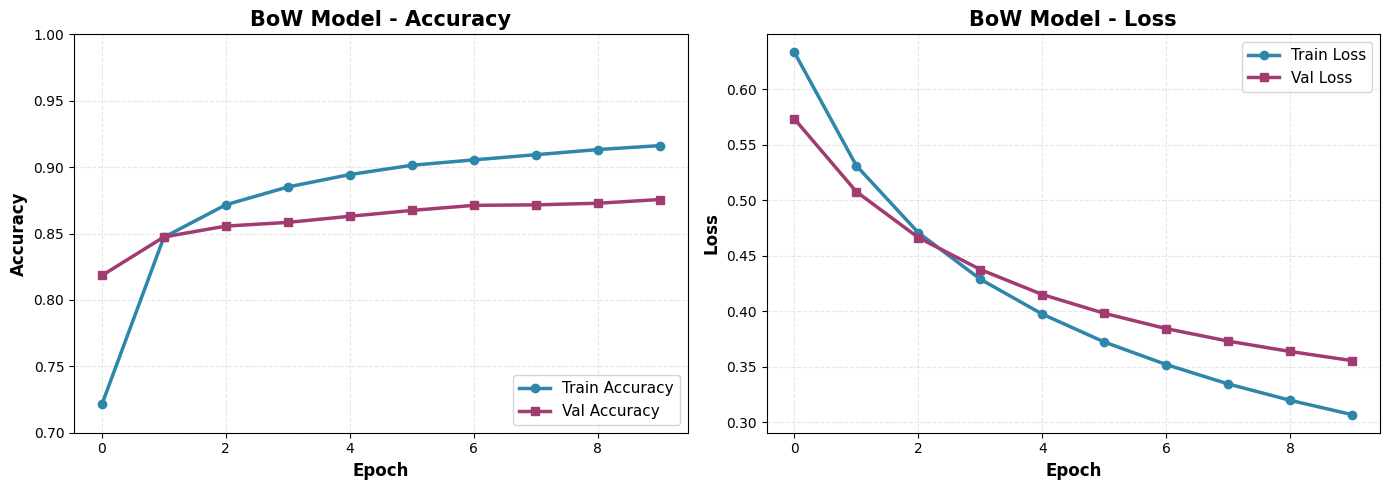

In [ ]:
# Evaluate on test setz
bow_results = model_bow.evaluate(X_test_bow, test_labels, verbose=0)
bow_accuracy = bow_results[1]

print(f"\nBoW Model Test Accuracy: {bow_accuracy:.4f}")
print(f"BoW Model Test Loss: {bow_results[0]:.4f}")
print(f"BoW Model Test Precision: {bow_results[2]:.4f}")
print(f"BoW Model Test Recall: {bow_results[3]:.4f}")

# Get predictions
y_pred_bow_prob = model_bow.predict(X_test_bow, verbose=0)
y_pred_bow = (y_pred_bow_prob > 0.5).astype(int).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BoW Accuracy
axes[0].plot(history_bow.history['accuracy'], label='Train Accuracy',
             linewidth=2.5, color='#2E86AB', marker='o', markersize=6)
axes[0].plot(history_bow.history['val_accuracy'], label='Val Accuracy',
             linewidth=2.5, color='#A23B72', marker='s', markersize=6)
axes[0].set_title('BoW Model - Accuracy', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11, loc='lower right')
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_ylim([0.7, 1.0])

# BoW Loss
axes[1].plot(history_bow.history['loss'], label='Train Loss',
             linewidth=2.5, color='#2E86AB', marker='o', markersize=6)
axes[1].plot(history_bow.history['val_loss'], label='Val Loss',
             linewidth=2.5, color='#A23B72', marker='s', markersize=6)
axes[1].set_title('BoW Model - Loss', fontsize=15, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11, loc='upper right')
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('bow_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## TF-IDF (Term Frequency-Inverse Document Frequency)

To improve upon the raw-frequency limitations of BoW, the project applies TF-IDF vectorization. TF-IDF assigns higher weights to words that are rare but influential, while down-weighting very common words that appear across many reviews. This helps the model better differentiate between subtle sentiment cues. The same logistic regression architecture is trained using TF-IDF vectors, allowing a direct performance comparison with the BoW model. TF-IDF is known to enhance model accuracy by capturing relevance instead of mere frequency, making this section critical for evaluating more informative features.

### Feature Extraction

In [ ]:
vectorizer_tfidf = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='tf_idf',
    output_sequence_length=None
)

# Adapt to training data
vectorizer_tfidf.adapt(preprocessed_train_data)

# Transform data
X_train_tfidf = vectorizer_tfidf(preprocessed_train_data).numpy()
X_test_tfidf = vectorizer_tfidf(preprocessed_test_data).numpy()

print(f"TF-IDF Training shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer_tfidf.get_vocabulary())}")

TF-IDF Training shape: (25000, 10000)
TF-IDF Test shape: (25000, 10000)
Vocabulary size: 10000


### Training

In [ ]:
# Build Logistic Regression Model with TF-IDF
model_tfidf = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Logistic Regression
], name='TF-IDF_Model')

model_tfidf.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model_tfidf.summary()

# Train the model
history_tfidf = model_tfidf.fit(
    X_train_tfidf, train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    verbose=1
)

Model: "TF-IDF_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,001 (39.07 KB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5926 - loss: 0.7475 - precision_1: 0.5966 - recall_1: 0.6392 - val_accuracy: 0.8138 - val_loss: 0.4698 - val_precision_1: 0.8461 - val_recall_1: 0.7614
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8549 - loss: 0.4110 - precision_1: 0.8758 - recall_1: 0.8279 - val_accuracy: 0.8622 - val_loss: 0.3877 - val_precision_1: 0.8515 - val_recall_1: 0.8732
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9064 - loss: 0.3182 - precision_1: 0.9049 - recall_1: 0.9092 - val_accuracy: 0.8734 - val_loss: 0.3531 - val_precision_1: 0.8631 - val_recall_1: 0.8838
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9234 - loss: 0.2723 - precision_1: 0.9246 - recall_1: 0.9237 - val_accuracy: 0.8766 - val_loss: 0.3351 - val_precision_1: 0.8672 - val_recall_1: 0.8858
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9326 - loss: 0.2436 - precision_1: 0.9318 - recall_1: 0.9345 - val_

### Evaluation


Evaluating TF-IDF model on test set...

TF-IDF Model Test Accuracy: 0.4963
TF-IDF Model Test Loss: 1.7923
TF-IDF Model Test Precision: 0.4963
TF-IDF Model Test Recall: 0.4987


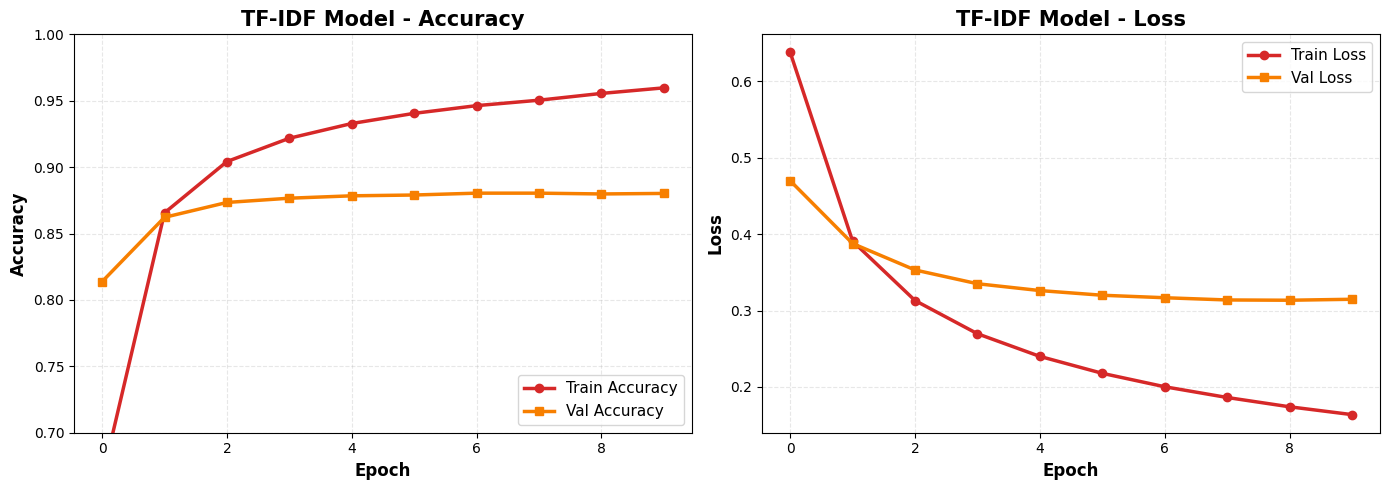

In [ ]:
# Evaluate on test set
print("\nEvaluating TF-IDF model on test set...")
tfidf_results = model_tfidf.evaluate(X_test_tfidf, test_labels, verbose=0)
tfidf_accuracy = tfidf_results[1]

print(f"\nTF-IDF Model Test Accuracy: {tfidf_accuracy:.4f}")
print(f"TF-IDF Model Test Loss: {tfidf_results[0]:.4f}")
print(f"TF-IDF Model Test Precision: {tfidf_results[2]:.4f}")
print(f"TF-IDF Model Test Recall: {tfidf_results[3]:.4f}")

# Get predictions
y_pred_tfidf_prob = model_tfidf.predict(X_test_tfidf, verbose=0)
y_pred_tfidf = (y_pred_tfidf_prob > 0.5).astype(int).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# TF-IDF Accuracy
axes[0].plot(history_tfidf.history['accuracy'], label='Train Accuracy',
             linewidth=2.5, color='#D62828', marker='o', markersize=6)
axes[0].plot(history_tfidf.history['val_accuracy'], label='Val Accuracy',
             linewidth=2.5, color='#F77F00', marker='s', markersize=6)
axes[0].set_title('TF-IDF Model - Accuracy', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11, loc='lower right')
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_ylim([0.7, 1.0])

# TF-IDF Loss
axes[1].plot(history_tfidf.history['loss'], label='Train Loss',
             linewidth=2.5, color='#D62828', marker='o', markersize=6)
axes[1].plot(history_tfidf.history['val_loss'], label='Val Loss',
             linewidth=2.5, color='#F77F00', marker='s', markersize=6)
axes[1].set_title('TF-IDF Model - Loss', fontsize=15, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11, loc='upper right')
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('tfidf_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluation & Comparison

This section thoroughly evaluates both models using industry-standard metrics such as accuracy, precision, recall, F1-score, and confusion matrices. These metrics allow the team to understand not only how often the models are correct, but also how they behave in cases of misclassification. Visualizations of training progress, including accuracy and loss curves, help identify issues like overfitting or underfitting. The comparison between BoW and TF-IDF provides data-driven insight into which vectorization method is more effective and stable for sentiment analysis use cases.

In [ ]:
def calculate_metrics(y_true, y_pred):
    """Calculate the 5 key evaluation metrics manually."""
    # Confusion Matrix Components
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    total = len(y_true)

    # 1. ACCURACY
    accuracy = (tp + tn) / total

    # 2. PRECISION
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # 3. RECALL
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # 4. F1-SCORE
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # 5. CONFUSION MATRIX
    confusion_matrix = np.array([[tn, fp], [fn, tp]])

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': confusion_matrix
    }

# Calculate metrics for both models
bow_metrics = calculate_metrics(test_labels, y_pred_bow)
tfidf_metrics = calculate_metrics(test_labels, y_pred_tfidf)

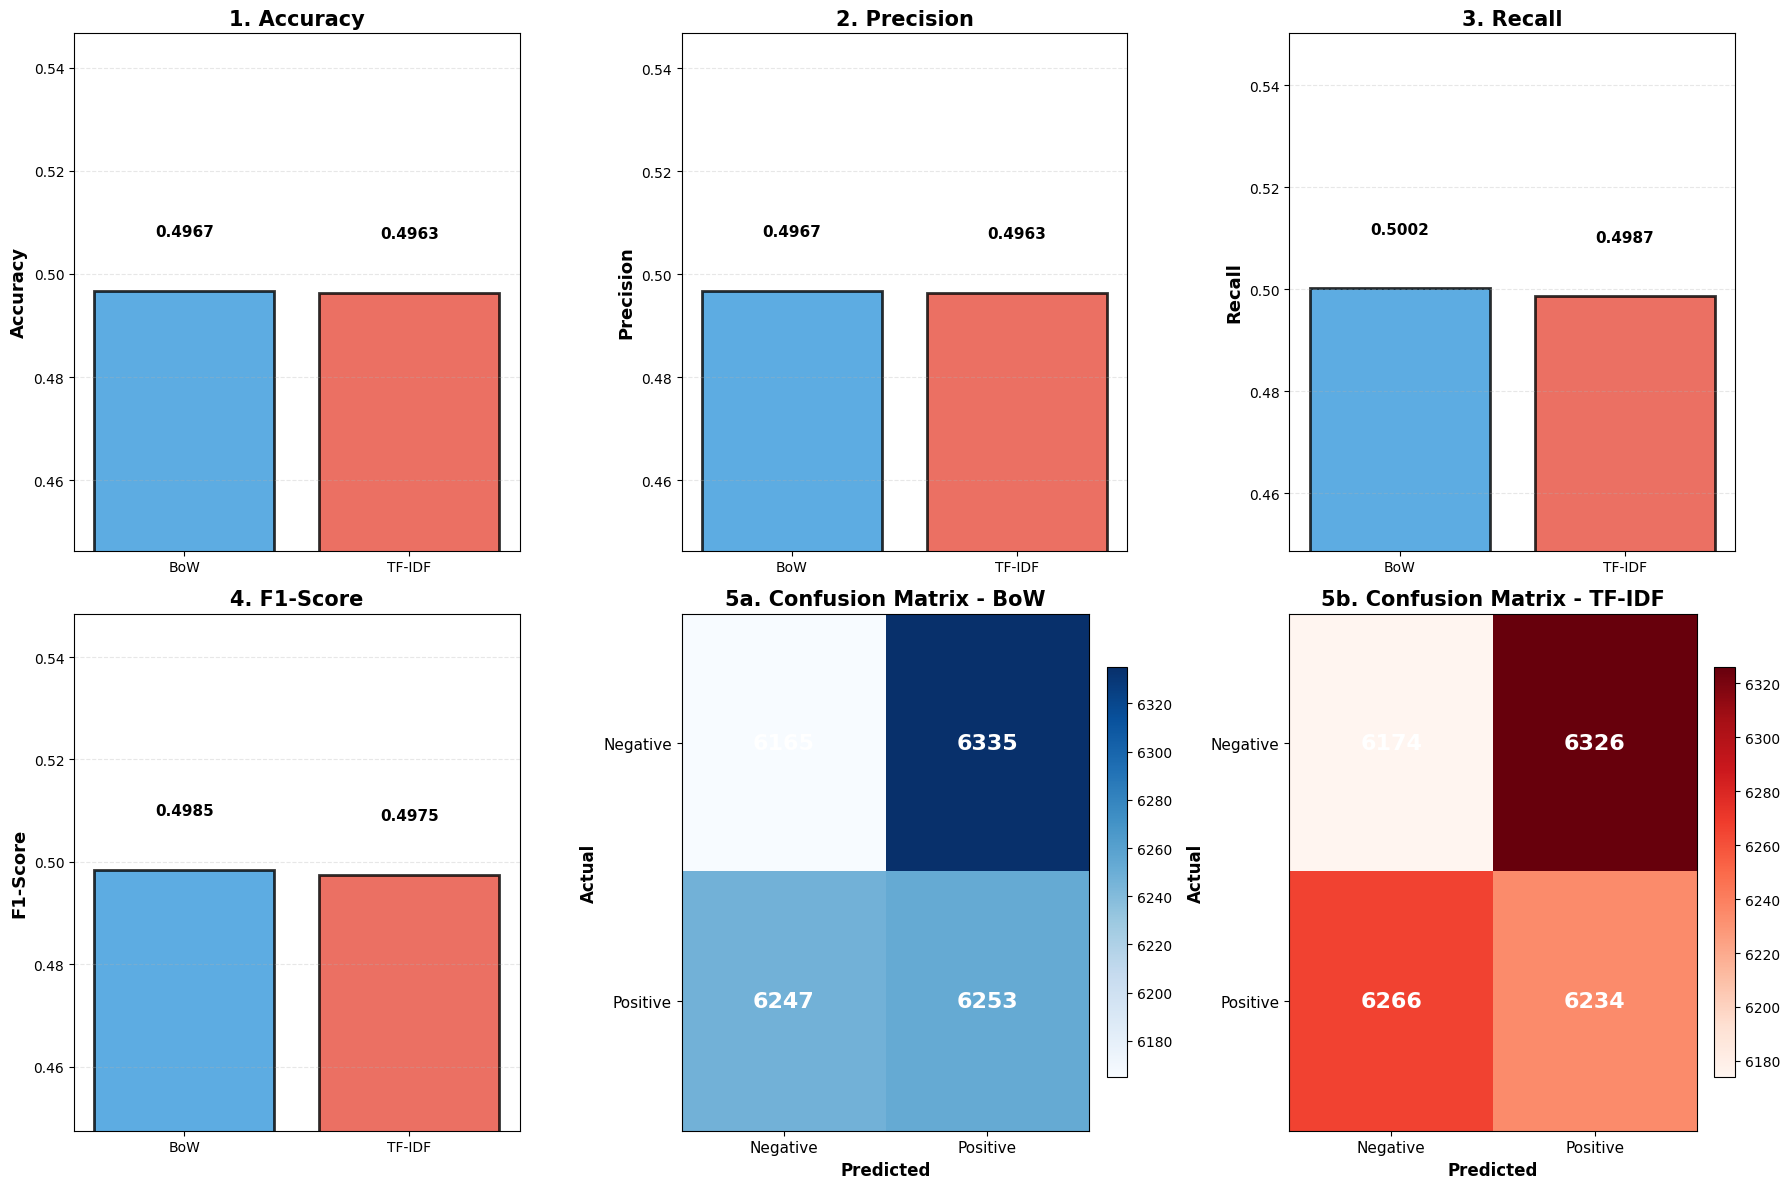

In [ ]:
# Dynamically compute limits so bars are inside the chart
def set_dynamic_ylim(ax, values):
    ymin = min(values) - 0.05
    ymax = max(values) + 0.05
    ax.set_ylim([ymin, ymax])

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
methods = ['BoW', 'TF-IDF']
accuracies = [bow_metrics['accuracy'], tfidf_metrics['accuracy']]
colors = ['#3498db', '#e74c3c']

bars = ax1.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('1. Accuracy', fontsize=15, fontweight='bold')
set_dynamic_ylim(ax1, accuracies)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, v) in enumerate(zip(bars, accuracies)):
    ax1.text(bar.get_x() + bar.get_width()/2., v + 0.01,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Precision Comparison
ax2 = axes[0, 1]
precisions = [bow_metrics['precision'], tfidf_metrics['precision']]

bars = ax2.bar(methods, precisions, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax2.set_title('2. Precision', fontsize=15, fontweight='bold')
set_dynamic_ylim(ax2, precisions)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, v) in enumerate(zip(bars, precisions)):
    ax2.text(bar.get_x() + bar.get_width()/2., v + 0.01,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Recall Comparison
ax3 = axes[0, 2]
recalls = [bow_metrics['recall'], tfidf_metrics['recall']]

bars = ax3.bar(methods, recalls, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_ylabel('Recall', fontsize=13, fontweight='bold')
ax3.set_title('3. Recall', fontsize=15, fontweight='bold')
set_dynamic_ylim(ax3, recalls)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, v) in enumerate(zip(bars, recalls)):
    ax3.text(bar.get_x() + bar.get_width()/2., v + 0.01,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 4. F1-Score Comparison
ax4 = axes[1, 0]
f1_scores = [bow_metrics['f1_score'], tfidf_metrics['f1_score']]

bars = ax4.bar(methods, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax4.set_title('4. F1-Score', fontsize=15, fontweight='bold')
set_dynamic_ylim(ax4, f1_scores)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, v) in enumerate(zip(bars, f1_scores)):
    ax4.text(bar.get_x() + bar.get_width()/2., v + 0.01,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 5. Confusion Matrix - BoW
ax5 = axes[1, 1]
im1 = ax5.imshow(bow_metrics['confusion_matrix'], cmap='Blues', aspect='auto', interpolation='nearest')
ax5.set_xticks([0, 1])
ax5.set_yticks([0, 1])
ax5.set_xticklabels(['Negative', 'Positive'], fontsize=11)
ax5.set_yticklabels(['Negative', 'Positive'], fontsize=11)
ax5.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax5.set_title('5a. Confusion Matrix - BoW', fontsize=15, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = ax5.text(j, i, f'{bow_metrics["confusion_matrix"][i, j]}',
                       ha="center", va="center",
                       color="white" if bow_metrics['confusion_matrix'][i, j] > bow_metrics['confusion_matrix'].max()/2 else "black",
                       fontsize=16, fontweight='bold')
plt.colorbar(im1, ax=ax5, fraction=0.046, pad=0.04)

# 6. Confusion Matrix - TF-IDF
ax6 = axes[1, 2]
im2 = ax6.imshow(tfidf_metrics['confusion_matrix'], cmap='Reds', aspect='auto', interpolation='nearest')
ax6.set_xticks([0, 1])
ax6.set_yticks([0, 1])
ax6.set_xticklabels(['Negative', 'Positive'], fontsize=11)
ax6.set_yticklabels(['Negative', 'Positive'], fontsize=11)
ax6.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax6.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax6.set_title('5b. Confusion Matrix - TF-IDF', fontsize=15, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = ax6.text(j, i, f'{tfidf_metrics["confusion_matrix"][i, j]}',
                       ha="center", va="center",
                       color="white" if tfidf_metrics['confusion_matrix'][i, j] > tfidf_metrics['confusion_matrix'].max()/2 else "black",
                       fontsize=16, fontweight='bold')
plt.colorbar(im2, ax=ax6, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## Testing

Finally, a unified prediction pipeline is implemented for real-world testing. This pipeline performs the same preprocessing used during model training—lowercasing, stopword removal, and vectorization—before sending the input through the trained models. This ensures consistency, prevents data leakage, and simulates actual deployment conditions. The system returns sentiment predictions along with confidence levels, enabling practical evaluation of how the model responds to new and unseen user-generated text.

In [ ]:
def predict_sentiment(review_text, method='both'):
    """Predict sentiment of a custom review."""
    processed = remove_stopwords(review_text.lower())

    results = {}

    if method in ['bow', 'both']:
        bow_features = vectorizer_bow([processed]).numpy()
        bow_prob = model_bow.predict(bow_features, verbose=0)[0][0]
        results['BoW'] = {
            'prediction': 'Positive' if bow_prob > 0.5 else 'Negative',
            'confidence': bow_prob * 100 if bow_prob > 0.5 else (1 - bow_prob) * 100
        }

    if method in ['tfidf', 'both']:
        tfidf_features = vectorizer_tfidf([processed]).numpy()
        tfidf_prob = model_tfidf.predict(tfidf_features, verbose=0)[0][0]
        results['TF-IDF'] = {
            'prediction': 'Positive' if tfidf_prob > 0.5 else 'Negative',
            'confidence': tfidf_prob * 100 if tfidf_prob > 0.5 else (1 - tfidf_prob) * 100
        }

    return results

In [ ]:
# Test examples
test_reviews = [
    "This movie was absolutely amazing! I loved every minute of it. Best film of the year!",
    "Terrible film, complete waste of time. Very disappointing and boring.",
    "The acting was decent but the plot was confusing and slow paced.",
    "While everybody's saying that this movie was a waste of time. I find it the opposite!",
    "It was surprisingly disappointing in a way that felt strangely satisfying, though I’m not sure if that means it was good or just less bad than expected."
]

for i, review in enumerate(test_reviews, 1):
    print(f"\nReview {i}: \"{review}\"")
    results = predict_sentiment(review)
    for method, result in results.items():
        emoji = "😊" if result['prediction'] == 'Positive' else "😞"
        print(f"  {method:8s}: {result['prediction']:8s} {emoji} (Confidence: {result['confidence']:.2f}%)")


Review 1: "This movie was absolutely amazing! I loved every minute of it. Best film of the year!"
  BoW     : Positive 😊 (Confidence: 58.56%)
  TF-IDF  : Positive 😊 (Confidence: 65.02%)

Review 2: "Terrible film, complete waste of time. Very disappointing and boring."
  BoW     : Negative 😞 (Confidence: 73.48%)
  TF-IDF  : Negative 😞 (Confidence: 88.66%)

Review 3: "The acting was decent but the plot was confusing and slow paced."
  BoW     : Negative 😞 (Confidence: 63.88%)
  TF-IDF  : Negative 😞 (Confidence: 67.40%)

Review 4: "While everybody's saying that this movie was a waste of time. I find it the opposite!"
  BoW     : Negative 😞 (Confidence: 54.55%)
  TF-IDF  : Negative 😞 (Confidence: 53.77%)

Review 5: "It was surprisingly disappointing in a way that felt strangely satisfying, though I’m not sure if that means it was good or just less bad than expected."
  BoW     : Negative 😞 (Confidence: 53.19%)
  TF-IDF  : Positive 😊 (Confidence: 54.39%)


# Summary

Pipeline performs every major NLP step, in order:
1. Token Reconstruction -
Turn numeric IMDB sequences into readable English sentences.
2. Stopword Removal -
Remove noise words like “the”, “is”, “and”.
3. Text Cleaning & Normalization -
Prepare text for machine consumption.
4. Exploratory Data Analysis -
Inspect which words are most frequent in positive vs negative reviews.
5. Vectorization (Feature Extraction) -
Convert text into numerical features:
•	Bag-of-Words
•	TF-IDF
6. Logistic Regression Modeling -
Train two different models on different feature sets.
7. Model Evaluation -
Compute and visualize accuracy, precision, recall, F1, confusion matrices.
8. Prediction Pipeline -
Take real human input → clean it → vectorize it → classify it.


The file performs a complete NLP workflow: it begins by importing Keras’ IMDB dataset, which contains reviews represented as integer sequences. With the special tokens [START] = 1, [OOV] = 2, and all real words starting from index 3, the file reconstructs the original text by reversing the IMDB word index. It then converts numeric reviews back into readable English using the translate() function. This step is essential because IMDB provides no raw sentences, and all NLP tasks require text.

Next, the file downloads a Kaggle stopword list and removes common but uninformative words to reduce noise and emphasize sentiment-heavy terms. After cleaning the text, it performs Exploratory Data Analysis by counting and visualizing the top 20 most frequent words in positive and negative reviews. This validates that preprocessing worked correctly and helps identify sentiment-driven vocabulary.

The script then transforms text into numerical features using two classical NLP vectorization techniques: Bag-of-Words (simple word counts) and TF-IDF (importance-weighted word features). Both vectorizers are adapted on the preprocessed training text and used to build feature matrices for training and testing.

Two logistic regression models are trained — one using BoW features and one using TF-IDF features — each built with a single Dense layer and sigmoid activation. They are optimized with binary crossentropy and monitored with accuracy, precision, and recall over 10 epochs. Training and validation curves are plotted to diagnose underfitting, overfitting, and stability.
For evaluation, the file computes accuracy, precision, recall, F1-score, and confusion matrices using a custom metrics function. It also visualizes these metrics side-by-side for BoW and TF-IDF to compare which representation performs better.

Finally, the script includes a production-style inference function that takes any user sentence, lowercases it, removes stopwords, vectorizes it with the same transformations used during training, runs predictions through both models, and returns the sentiment plus confidence percentage. This demonstrates how the model behaves on real-world text and ensures the preprocessing pipeline is consistent from training to inference.

